# BIG3003, Spring 2022
Homework #8 is due on June 14, 2022  
융합전자공학부 2018006171 김경호

## 목차

1. [주제선정](#주제선정)
2. [Data set 설명](#Data-set-설명)
3. [탐색적 데이터 분석, EDA](#탐색적-데이터-분석)
4. [특성공학, Feature Engineering](#Feature-Engineering)
5. [모델개발 및 학습](#모델개발-및-학습)
6. [결론](#결론)


# CPU 설계와 Branch Hazards

``` c
x1 = 1;
x2 = 0;
if (x1 < x2)
  x2 - x1;
else
  x1 - x2;
```

3번째 라인 if statement 결과 다음에 어떤 명령을 실행할까. x1이 x2보다 크니 else 뒤의 x1 - x2가 실행될 것 같지만 이 코드를 실행하고 있는 컴퓨터의 CPU에 Branch Prediction이 없다면  둘 다 실행된다. 지금은 간단한 예시이지만 프로그램이 커지면 Branch Prediction의 정확성은 그 CPU의 성능에 큰 영향을 미친다. 이를 해결하기 위해 Fetch 단계에서 주어진 정보만으로 미래에 Branch할 것인지 안할 것인지를 예측해서 성능저하를 최소화하고자 한다. 이를 dynamic branch prediction이라 한다.

컴퓨터 구조론 파이널 프로젝트로 이미 CPU를 만들었고, dynamic branch predictor를 추가하려고 한다. 만든 CPU는 RISC-V 5 stage pipeline을 따르고 있고 fetch 단계에서 predict를 할 것이다.

# Data set 설명

3rd Championship Branch Prediction의 simulator를 이용하여 만들어진 dataset이고 우리는 그 중 integer benchmark 프로그램인 INT04와 INT03을 각각 training, test set으로 사용하기로 한다.feature는 다음과 같다.

1. PC of an Instruction - uint32_t - converted into binary (first 32 columns)
2. current state of GSHARE table size 64 - int8_t array - global history array of previous conditional moves in the 3. form of saturation counters - normalized to [0,1] (next 64 columns)
4. current state of GA table - uint8_t array size 48 - global address array of previous instruction's PC(only lower 8 bits taken) - converted to binary(next 48*8 columns)
5. Target Taken/Not Taken

피처의 이름을 통해 이 데이터 셋은 Gloabal Branch Prediction 방법을 사용하는 하드웨어로부터 얻어진 결과임을 추측할 수 있다. 내가 제작한 CPU는 BTB만 가지고 있기 때문에 2번 피처는 사용하지 않는다.

## 라이브러리, 데이터 로드

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import sklearn

In [ ]:
col = ['clock']

def column_name_create(col):
    if len(col) != 1:
      return
    for i in range(32):
        col.append('pc' + str(31 - i))
    for i in range(64):
        col.append('gshare' + str(i))
    for i in range(48):
        for j in range(8):
            col.append('ga' + str(i) + 'x' + str(7 - j))
    col.append('bt')
        
def load_I04(col):
    column_name_create(col)
    df_I04 = pd.read_csv('./data/I04.csv', delimiter=',', names = col)
    df_I04.drop(0, inplace = True)

    dropCol = []
    for i in range(64):
        dropCol.append('gshare' + str(i))
    df_I04.drop(labels = dropCol, axis = 1, inplace = True)

    df_I04.index = range(df_I04.shape[0])
    df_I04.dataframeName = 'I04.csv'
    print("df_I04 loaded")
    return df_I04

def load_I03(col):
    column_name_create(col)
    df_I03 = pd.read_csv('./data/INT03.csv', delimiter=',', names = col)
    df_I03 = df_I03.drop(0)

    dropCol = []
    for i in range(64):
        dropCol.append('gshare' + str(i))
    df_I03.drop(labels = dropCol, axis = 1, inplace = True)

    df_I03.index = range(df_I03.shape[0])
    df_I03.dataframeName = 'I03.csv'
    print("df_I03 loaded")
    return df_I03

df_I04 = load_I04(col)
df_I03 = load_I03(col)

df_I04 loaded
df_I03 loaded


In [ ]:
# 주어진 데이터 셋이 너무 커 노트북에서 작업이 안된다.
# 어쩔 수 없이 eda부분만 1000개를 뽑아낸 데이터 프레임을 이용한다. 실제 모델 학습 시에는 모든 데이터를 사용한다.
df_eda = df_I04.loc[:1000, :]
df_eda.head()

,clock,pc31,pc30,pc29,pc28,pc27,pc26,pc25,pc24,pc23,...,ga46x0,ga47x7,ga47x6,ga47x5,ga47x4,ga47x3,ga47x2,ga47x1,ga47x0,bt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


# 탐색적 데이터 분석

먼저, pc값들을 우리가 이해할 수 있도록 고친다. 또, 가장 직전에 했던 Branch Taken이 얼마나 멀리 떨어져 있는지를 나타내는 피처를 추가하겠다. 데이터 셋의 크기가 너무 크기 때문에 멀티코어를 사용하는 코드를 추가했다. dfChange.py라는 파일에 각 함수를 넣었다.

In [ ]:
import multiprocessing as mp
from multiprocessing import Pool
from dfChange import changePC, addLastBT, floatToInt, rearrangeDF

cores = mp.cpu_count()

def parallel_df(df, func, n_cores):
  df_split = np.array_split(df, n_cores)
  pool = Pool(n_cores)
  df = pd.concat(pool.map(func, df_split))
  pool.close()
  pool.join()
  return df

df_eda = parallel_df(df_eda, rearrangeDF, cores)
print("df_eda processed")

df_eda processed


In [ ]:
df_I04 = parallel_df(df_I04, rearrangeDF, cores)
print("df_I04 processed")
df_I04.to_csv("./data/PreI04.csv"

df_I04 processed


In [ ]:
df_I03 = parallel_df(df_I03, rearrangeDF, cores)
print("df_I03 processed")
df_I03.to_csv("./data/PreI03.csv")

df_I03 processed


In [ ]:
df_eda.describe()

,pc,GA0,GA1,GA2,GA3,GA4,GA5,GA6,GA7,GA8,...,GA41,GA42,GA43,GA44,GA45,GA46,GA47,LastBT,clk,BT
count,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.00000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,4.286558e+06,115.038961,115.175824,115.327672,115.509491,115.696304,115.892108,115.962038,116.04995,116.155844,...,120.027972,120.186813,120.302697,120.439560,120.591409,120.773227,120.960040,3.166833,500.000000,0.159840
std,4.947532e+03,67.061341,66.966059,66.876906,66.810420,66.748526,66.696254,66.611264,66.51607,66.415433,...,64.163644,64.062938,63.950131,63.838911,63.732832,63.648013,63.567558,2.962286,289.108111,0.366641
min,4.276535e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
25%,4.284248e+06,50.000000,50.000000,50.000000,50.000000,50.000000,55.000000,55.000000,55.00000,55.000000,...,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,1.000000,250.000000,0.000000
50%,4.285336e+06,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.00000,116.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,3.000000,500.000000,0.000000
75%,4.285380e+06,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.00000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,4.000000,750.000000,0.000000
max,4.312100e+06,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.00000,251.000000,...,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,17.000000,1000.000000,1.000000


## 스케일링

Branch Taken을 표현하는 피처들은 그 프로그램의 instruction 위치에 의한 영향이 크기 때문에 비율로 표현하는 것이 좋다고 생각한다. min-max scaling을 하자.

In [4]:
from sklearn.preprocessing import MinMaxScaler

def scalingDF(df):
  names = df.columns.to_list()
  scaler = MinMaxScaler()    
  scaler.fit(df[names[:-1]])
  df_scaled = scaler.transform(df[names[:-1]])
  df_scaled = pd.DataFrame(df_scaled, columns= names[:-1])
  df_scaled['BT'] = df['BT']
  return df_scaled

def scalingTest(df):
  global df_I04
  names = df.columns.to_list()
  scaler = MinMaxScaler()    
  scaler.fit(df_I04[names[:-1]])
  df_scaled = scaler.transform(df[names[:-1]])
  df_scaled = pd.DataFrame(df_scaled, columns= names[:-1])
  df_scaled['BT'] = df['BT']
  return df_scaled

df_train = pd.read_csv('./data/train.csv', delimiter=',')
df_train.drop(columns=df_train.columns[0], axis = 1, inplace=True)
df_test = pd.read_csv('./data/test.csv', delimiter=',')
df_test.drop(columns=df_test.columns[0], axis = 1, inplace=True)
df_eda = df_train.iloc[:1000, :]

#df_scaled = scalingDF(df_eda)
#df_train = scalingDF(df_I04)
#df_test = scalingTest(df_I03)

#df_train.to_csv('./data/train.csv')
#df_test.to_csv('./data/test.csv')
names = df_train.columns.to_list()

## 데이터 패턴 확인

데이터셋 자체가 클락에 따른 시계열 데이터이다. 주기성을 가지고 있는지 확인하기 위해서 bt를 plot한다.
아래 그래프를 보면, 5 클럭 정도의 일정한 주기를 따라 Branch Taken됨을 확인 할 수 있다.

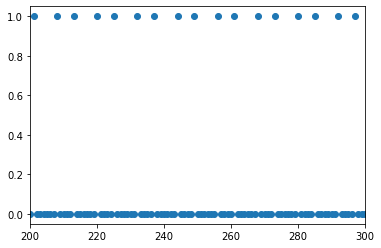

In [ ]:
plt.scatter(y='BT', x = df_eda.index, data = df_eda)
plt.xlim([200, 300])
plt.show()

## 주성분 분석

관측치가 정말 많기 때문에 차원축소를 하지 않아도 된다고 생각하지만, 수업시간에 배운 내용을 적용하기 위해 PCA와 t-sne를 사용한다.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(df_train.iloc[:,:-1])
df_pca = pca.transform(df_train.iloc[:,:-1])
df_pca = pd.DataFrame(df_pca, columns = ['component 0', 'component 1', 'component 2'])

print(pca.explained_variance_ratio_)


[0.27349536 0.27186931 0.05144001]


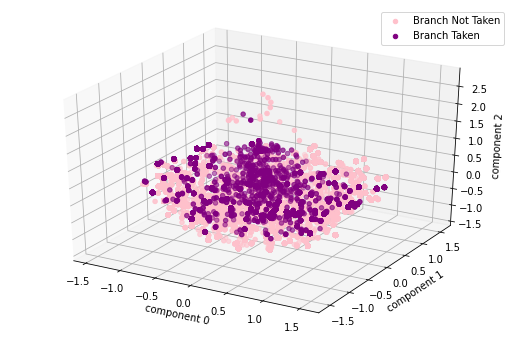

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 세팅
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# class target 정보 불러오기 
df_pca['BT'] = df_train['BT']

# target 별 분리
pca_df_0 = df_pca[df_pca['BT'] == 0]
pca_df_1 = df_pca[df_pca['BT'] == 1]

# target 별 시각화
ax.scatter(pca_df_0['component 0'], pca_df_0['component 1'], pca_df_0['component 2'], color = 'pink', label = 'Branch Not Taken')
ax.scatter(pca_df_1['component 0'], pca_df_1['component 1'], pca_df_1['component 2'], color = 'purple', label = 'Branch Taken')

ax.set_xlabel('component 0')
ax.set_ylabel('component 1')
ax.set_zlabel('component 2')
ax.legend()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

names = df_eda.columns.to_list()
np_tsne = TSNE(n_components = 3).fit_transform(df_eda[names[:-1]])
tsne_df = pd.DataFrame(np_tsne, columns = ['component 0', 'component 1', 'component 2'])

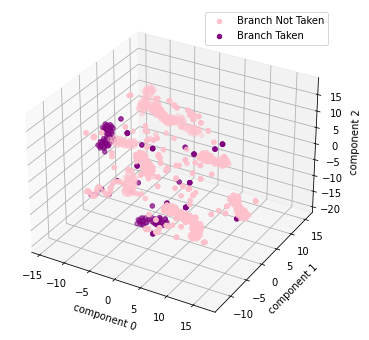

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 세팅
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# class target 정보 불러오기 
tsne_df['BT'] = df_eda['BT']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['BT'] == 0]
tsne_df_1 = tsne_df[tsne_df['BT'] == 1]

# target 별 시각화
ax.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], tsne_df_0['component 2'], color = 'pink', label = 'Branch Not Taken')
ax.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], tsne_df_1['component 2'], color = 'purple', label = 'Branch Taken')

ax.set_xlabel('component 0')
ax.set_ylabel('component 1')
ax.set_zlabel('component 2')
ax.legend()
plt.show()

둘 다, 제대로 구분을 못하기 때문에 각 성분들이 무엇을 의미하는지 살펴보지 않았다.

## 결측치 및 데이터 범위 확인

In [ ]:
nanlist = df_eda.isnull().sum() / df_eda.shape[0]
for i in nanlist:
    if i != 0.0:
        print("there is nan")
else:
    print("there is not any nan")

ut = df_eda['BT'].unique()
print(ut)
print("the shape of the data frame is", df_eda.shape)

there is not any nan
[0 1]
the shape of the data frame is (1001, 52)


## Target label 확인

주어진 data set에서 branch instruction이 얼마나 있는지 확인해보자. 아래의 그래프를 통해서 우리가 만들어낸 모델이 반반 찍기가 되더라도 실제 데이터의 bt비율이 50%가 되지 않으므로 모델이 잘못되었음을 쉽게 알아낼 수 있다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


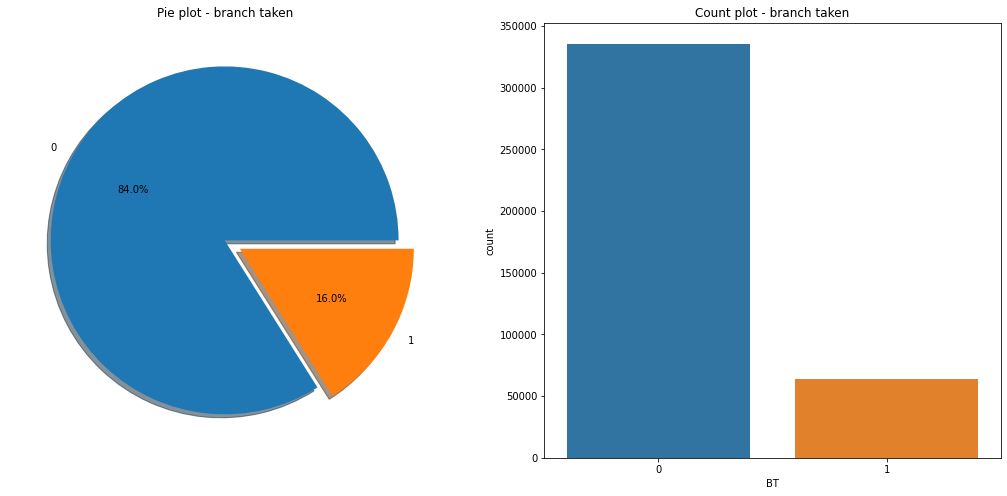

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['BT'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - branch taken')
ax[0].set_ylabel('')
sns.countplot('BT', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - branch taken')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


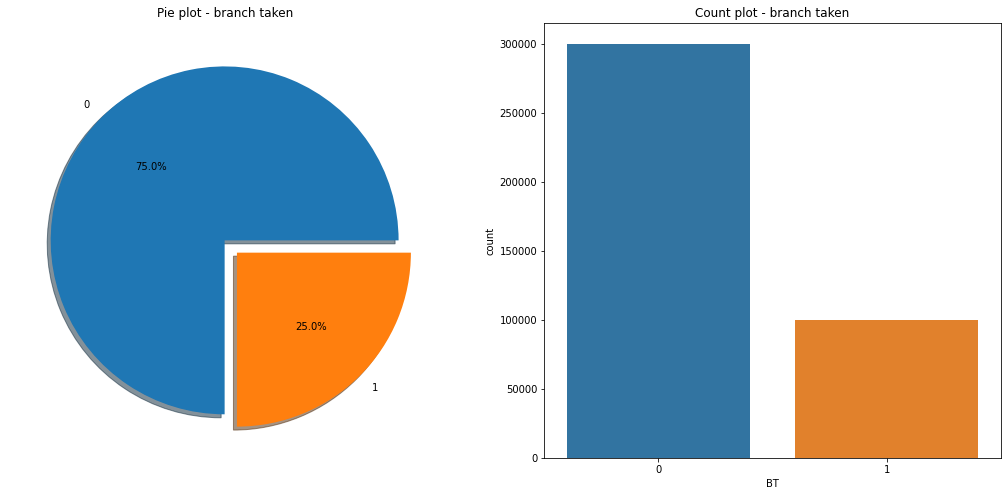

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_test['BT'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - branch taken')
ax[0].set_ylabel('')
sns.countplot('BT', data=df_test, ax=ax[1])
ax[1].set_title('Count plot - branch taken')

plt.show()

# Feature Engineering

EDA단계에서 가장 마지막으로 BT된 clk과의 거리를 의미하는 LastBT 피처를 추가했다. 스케일링은 min-max로 했다.

# 모델개발 및 학습

## LDA와 QDA, Logistic Regression

In [14]:
names = df_train.columns.to_list()

X = df_train[names[:-1]]
y = df_train['BT']

x_test = df_test[names[:-1]]
y_test = df_test['BT']

X_small = X[:1000]
y_small = y[:1000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

lda = LinearDiscriminantAnalysis()
lda.fit(X,y)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X,y)

logit = LogisticRegression()
logit.fit(X, y)

In [ ]:
from sklearn.metrics import confusion_matrix

lda_pred = lda.predict(x_test)
qda_pred = qda.predict(x_test)
logit_pred = logit.predict(x_test)

ldaConfusionMat = confusion_matrix(y_test, lda_pred)
qdaConfusionMat = confusion_matrix(y_test, qda_pred)
logitConfusionMat = confusion_matrix(y_test, logit_pred)

In [ ]:
print("lda error : ", (ldaConfusionMat[0][1] + ldaConfusionMat[1][0]) / (sum(ldaConfusionMat[0]) + sum(ldaConfusionMat[1])))
print("qda error : ", (qdaConfusionMat[0][1] + qdaConfusionMat[1][0]) / (sum(qdaConfusionMat[0]) + sum(qdaConfusionMat[1])))
print("logistic regression error : ", (logitConfusionMat[0][1] + logitConfusionMat[1][0]) / (sum(logitConfusionMat[0]) + sum(logitConfusionMat[1])))

lda error :  0.38703
qda error :  0.25001
logistic regression error :  0.147095


## Random Forest

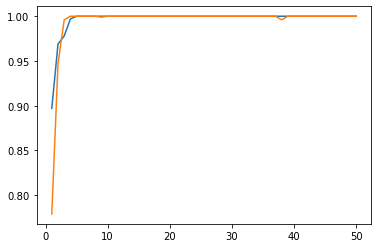

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mean_test_accuracy = []
train_accuracy = []
max_attributes = X_small.shape[1]
for max_depth in np.arange(1, max_attributes):
    model = RandomForestClassifier(max_depth=max_depth).fit(X_small, y_small)
    train_accuracy.append(accuracy_score(y_small, model.predict(X_small)))
    mean_test_accuracy.append(cross_val_score(model, x_test_small, y_test_small, scoring="accuracy", cv=5).mean())
    
    
plt.plot(np.arange(1, max_attributes), train_accuracy)
plt.plot(np.arange(1, max_attributes), mean_test_accuracy)
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
randomForest = RandomForestClassifier(max_depth = 10).fit(X_small, y_small)
randomForest_pred = randomForest.predict(x_test_small)
randomConfMat = confusion_matrix(y_test_small, randomForest_pred)

print("RandomForest error : ", (randomConfMat[0][1] + randomConfMat[1][0]) / (sum(randomConfMat[0]) + sum(randomConfMat[1])))

RandomForest error :  0.027


In [36]:
from sklearn.tree import export_graphviz
estimator = randomForest.estimators_[3]

export_graphviz(estimator, out_file='tree.dot',
                max_depth = 10,
                precision = 3,
                filled = True,
                rounded=True,
               )

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

## SVM

In [23]:
from sklearn.svm import SVC
import sklearn.metrics as mt

svm = SVC(kernel = 'linear')
svm.fit(X_small, y_small)
y_train_pred = svm.predict(X_small)
y_test_pred = svm.predict(x_test_small)

print("train data acc:", mt.accuracy_score(y_small, y_train_pred))
print("test data acc:", mt.accuracy_score(y_small, y_test_pred))

train data acc: 0.983
test data acc: 0.711


In [24]:
svm = SVC(kernel = 'rbf')
svm.fit(X_small, y_small)
y_train_pred = svm.predict(X_small)
y_test_pred = svm.predict(x_test_small)

print("train data acc:", mt.accuracy_score(y_small, y_train_pred))
print("test data acc:", mt.accuracy_score(y_small, y_test_pred))

train data acc: 0.99
test data acc: 0.84


## RNN(LSTM)

In [ ]:
x = df_train[names[:-1]].to_numpy()
y = df_train['BT'].to_numpy()

train_x, x_val = x[0 : 400000 - 400000 // 10].reshape(400000 - 400000 // 10, df_train.shape[1] - 1, 1), x[400000 - 400000 // 10 :].reshape(400000 // 10, df_train.shape[1] - 1, 1)
train_y, y_val = y[0 : 400000 - 400000 // 10], y[400000 - 400000 // 10 :]

X_test = df_test[names[:-1]].to_numpy().reshape(400000, df_test.shape[1] - 1, 1)
y_test = df_test['BT'].to_numpy()

In [ ]:
print(train_x.shape)
print(train_y.shape)

(360000, 51, 1)
(360000,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(LSTM(32))
  model.add(Dense(1, activation='sigmoid'))
  model.build(input_shape = (None, df_train.shape[1], 1))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  model.fit(train_x, train_y, epochs=10, batch_size=32, verbose=1, validation_data = (x_val, y_val))
  print("evaluate result")
  print()
  model.evaluate(X_test, y_test, batch_size=32)

Found GPU at: /device:GPU:0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
11250/11250 [==============================] - 58s 5ms/step - loss: 0.0537 - acc: 0.9827 - val_loss: 0.0038 - val_acc: 0.9994
Epoch 2/10
11250/11250 [==============================] - 55s 5ms/step - loss: 0.0045 - acc: 0.9990 - val_loss: 0.0016 - val_acc: 0.9998
Epoch 3/10
11250/11250 [==============================] - 58s 5ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 4.2744e-04 - val_acc: 0.9998
Epoch

# 결론

LDA와 QDA는 정규분포를 가정한 모델이다. 그에 반해 Logistic Regression은 모델에 대한 가정 없이 학습하기 때문에 더 성능이 좋다. svm의 경우 linear커널을 사용한 것보다 rbf커널을 사용한 것이 더 나은 성능을 보여주기 때문에 데이터가 선형적인 형태를 띄고 있지 않음을 알 수 있다. 최종적으로 RNN모델과 Random Forest 모델이 굉장히 높은 성능을 보여주었지만 Random Forest의 경우 Decision Forest 하나 하나를 전부 하드웨어로 표현할 시 Fetch단계에 포함되어야 하는 하드웨어 유닛의 수가 너무 많다. 그러므로 RNN모델이 가장 적합하다고 볼 수 있다.